In [1]:

from pathlib import Path
from h5py import File
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display
import json

In [8]:
dataset_path = Path('../../data/dataset_1000pts_diversified.hdf5')
final_assignements = {}
init_assignements = {}
metadata = {}
points_coords = {}
with File(dataset_path) as cache:
    for k,v in cache["final_assignements"].items():
        final_assignements[k] = np.copy(v)
    for k,v in cache["init_assignements"].items():
        init_assignements[k] = np.copy(v)
    for k,v in cache["metadata"].items():
        arr = np.copy(v)
        metadata[k] = {"SEED_POINTS": int(arr[0]), "SEED_ASSIGNS":int(arr[1]),
                       "NUM_CLUST": arr[2], "NUM_POINTS": arr[3], 
                       "INIT_CHOICE": arr[4], 
                       "IMPR_CLASS": arr[5], 
                       "IT_ORDER": arr[6], 
                       "init_cost": arr[7], "final_cost": arr[8], "num_iter": arr[9], "num_iter_glob": arr[10], "duration": arr[11],"dataset_key":k}
    for k,v in cache["points_coords"].items():
        points_coords[k] = np.copy(v)
df_number = pd.DataFrame(list(metadata.values()))
df = df_number.copy()
df.loc[df["INIT_CHOICE"] == 0,"INIT_CHOICE"] = "random"
df.loc[df["INIT_CHOICE"] == 1,"INIT_CHOICE"] = "kmeans+"
df.loc[df["IMPR_CLASS"] == 0,"IMPR_CLASS"] = "BI"
df.loc[df["IMPR_CLASS"] == 1,"IMPR_CLASS"] = "FI"
df.loc[df["IT_ORDER"] == 0,"IT_ORDER"] = "BACK"
df.loc[df["IT_ORDER"] != 0,"IT_ORDER"] = "other"
df.loc[:,"SEED"] = df["SEED_POINTS"].astype(str)+"_"+df["SEED_ASSIGNS"].astype(str) + "_" + df["INIT_CHOICE"].astype(str)
df_src = df.copy()
# print(df["IMPR_CLASS"].unique())
# print(df["INIT_CHOICE"].unique())
# display(df[df["INIT_CHOICE"] == "random"])

In [17]:
print(df["dataset_key"].unique())

['0,0,0,2,0,0' '0,0,0,2,1,0' '0,0,1,2,0,0' ... '999,9999,0,2,1,0'
 '999,9999,1,2,0,0' '999,9999,1,2,1,0']


C:\Users\robin\AppData\Local\Temp\ipykernel_10764\1895981543.py:4: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared.



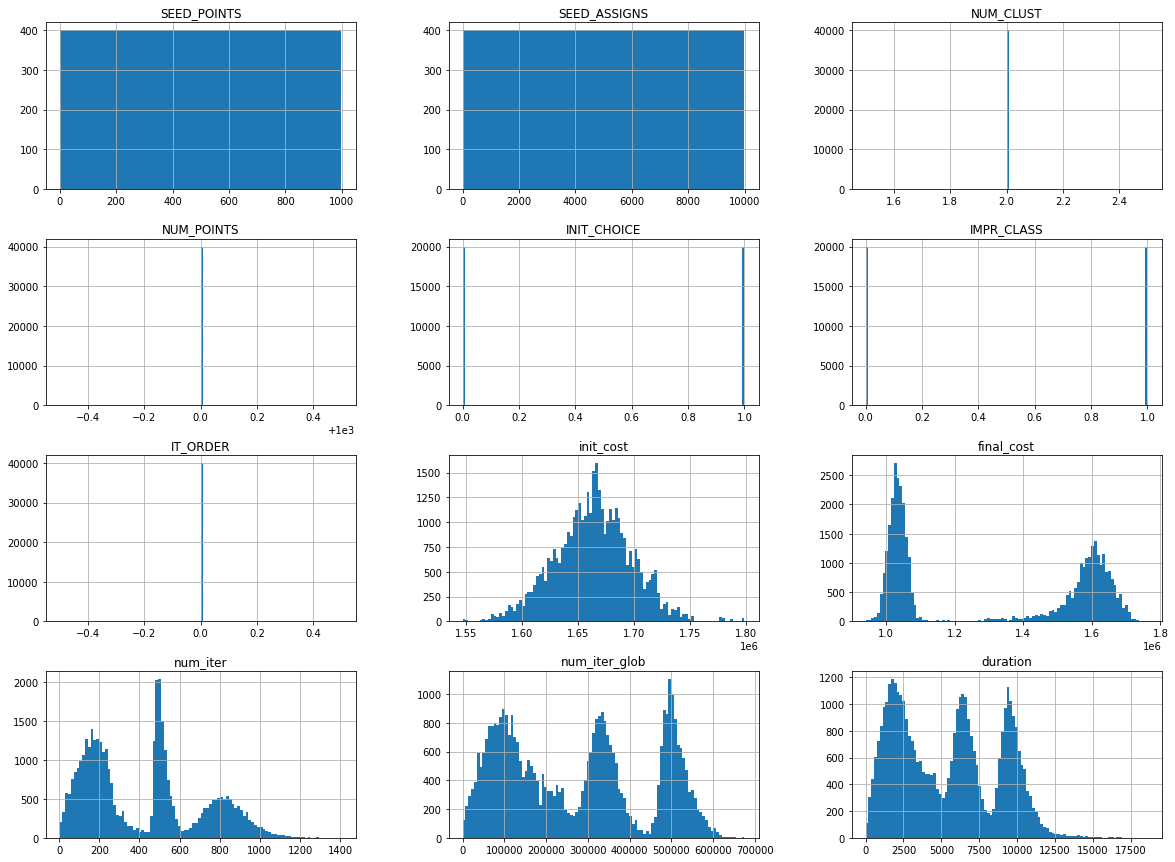

In [9]:
df_sel = df_number.query("NUM_CLUST == 2")
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df_sel.hist(bins=100,ax=ax)
fig.savefig(str(dataset_path.parent.parent / './images/dataset_stats.jpg'))

In [10]:

df["category"] = df["IMPR_CLASS"].astype(str)+"_"+df["INIT_CHOICE"].astype(str)
for num_clust in df["NUM_CLUST"].unique():
    df_tmp = df.query(f"NUM_CLUST == {num_clust}")
    for attr in ["init_cost","num_iter","num_iter_glob","duration","final_cost"]:
        fig = px.histogram(df_tmp,x=attr,color="category",nbins=1000)    
        fig.write_image(str(dataset_path.parent.parent / f'./images/dataset_stats_{attr}_{num_clust}_clust.jpg'))
fig.show()

In [11]:
df_cpy = df.copy()
try:
    df_cpy.drop(columns=["category"],inplace=True)
except KeyError:
    pass
df_orig = df_cpy.copy()
df_cpy.loc[df_cpy["IT_ORDER"]=="BACK","IT_ORDER"] = 0
df_cpy.loc[df_cpy["IT_ORDER"]=="other","IT_ORDER"] = -1
df_cpy.loc[df_cpy["INIT_CHOICE"]=="random","INIT_CHOICE"] = 0
df_cpy.loc[df_cpy["INIT_CHOICE"]=="kmeans+","INIT_CHOICE"] = 1
Ldf = []
for impr in ["FI","BI"]:
    df_impr = df_cpy.query(f"IMPR_CLASS == \'{impr}\'")
    df_impr = df_impr.drop(columns=["IMPR_CLASS","dataset_key"])
    df_impr.set_index("SEED",inplace=True)
    Ldf.append(df_impr)
new_df = (Ldf[0]-Ldf[1])
df_infos = df_orig.copy().query("IMPR_CLASS=='BI'").set_index("SEED")
for k in ["init_cost",attr,"num_iter","num_iter_glob","duration"]:
    df_infos[k] = new_df[k]
df_infos.reset_index(inplace=True)
display(df_infos)

,SEED,SEED_POINTS,SEED_ASSIGNS,NUM_CLUST,NUM_POINTS,INIT_CHOICE,IMPR_CLASS,IT_ORDER,init_cost,final_cost,num_iter,num_iter_glob,duration,dataset_key
0,0_0_random,0,0,2.0,1000.0,random,BI,other,0.0,2.450283e+04,194.0,-251324.0,-8055.0,"0,0,0,2,0,0"
1,0_0_kmeans+,0,0,2.0,1000.0,kmeans+,BI,other,0.0,0.000000e+00,30.0,-112767.0,-3457.0,"0,0,0,2,1,0"
2,0_1_random,0,1,2.0,1000.0,random,BI,other,0.0,8.498318e-09,346.0,-191665.0,-3653.0,"0,1,0,2,0,0"
3,0_1_kmeans+,0,1,2.0,1000.0,kmeans+,BI,other,0.0,0.000000e+00,30.0,-112767.0,-1452.0,"0,1,0,2,1,0"
4,0_2_random,0,2,2.0,1000.0,random,BI,other,0.0,1.629815e-09,282.0,-183181.0,-3053.0,"0,2,0,2,0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,999_9997_kmeans+,999,9997,2.0,1000.0,kmeans+,BI,other,0.0,0.000000e+00,12.0,-112585.0,-2243.0,"999,9997,0,2,1,0"
19996,999_9998_random,999,9998,2.0,1000.0,random,BI,other,0.0,4.975815e+05,-154.0,-408281.0,-7595.0,"999,9998,0,2,0,0"
19997,999_9998_kmeans+,999,9998,2.0,1000.0,kmeans+,BI,other,0.0,0.000000e+00,12.0,-112585.0,-2048.0,"999,9998,0,2,1,0"
19998,999_9999_random,999,9999,2.0,1000.0,random,BI,other,0.0,-6.984919e-10,262.0,-177126.0,-3203.0,"999,9999,0,2,0,0"


In [11]:
# num_clust = 2
# attr = attr
for num_clust in [4,8,16,2]:
    df_tmp = df_infos.query(f"NUM_CLUST == {num_clust}")
    for attr in ["init_cost","num_iter","num_iter_glob","duration","final_cost"]:
        df_rand = df_tmp.query(f"INIT_CHOICE == \'random\'")
        df_kmeans = df_tmp.query(f"INIT_CHOICE == \'kmeans+\'")
        fig = px.histogram(df_tmp,x=attr,color="INIT_CHOICE",
                           color_discrete_map = {'random':'blue','kmeans+':'red'},
                           histnorm="percent",
                           range_y=None, #if attr != "final_cost" else [0,5],
                           barmode="overlay",
                           nbins=500,title="FI-BI (mean in dotted line) "+ f"Mean random:{df_rand[attr].mean():.2f} ; "+f"Mean kmeans+:{df_kmeans[attr].mean():.2f}")  
        fig.add_vline(x=df_rand[attr].mean(),
               line=dict(dash= 'dot',color='blue')
               )
        fig.add_vline(x=df_kmeans[attr].mean(),
               line=dict(dash= 'dot',color='red')
               )
   
        fig.write_image(str(dataset_path.parent.parent / f'./images/dataset_stats_{attr}_{num_clust}_FI-BI_clust.jpg'))
fig.show()

In [16]:

dico_backup_best = {}
for attr in ["final_cost","duration"][::-1]:
   if attr not in dico_backup_best:
      dico_backup_best[attr] = {}
   for num_clust in [2]:
      df_tmp = df_infos.query(f"NUM_CLUST == {num_clust}")
      df_tmpcpy = df_tmp.copy()
      df_tmp.loc[df_tmpcpy[attr] > 0,attr] = "BI"
      df_tmp.loc[df_tmpcpy[attr] < 0,attr] = "FI"
      df_tmp.loc[df_tmpcpy[attr] == 0,attr] = "Equal"
      if num_clust not in dico_backup_best[attr]:
         dico_backup_best[attr][num_clust] = {}
      for index, row in df_tmp.iterrows():
         dico_backup_best[attr][num_clust][row["dataset_key"]] = row[attr]
      fig = px.histogram(df_tmp,x=attr,
                              # histnorm="percent",
                              range_y=None, #if attr != "final_cost" else [0,5],
                           #    barmode="overlay",
                              nbins=500,title="Suggestions")
      fig.write_image(str(dataset_path.parent.parent / f'./images/dataset_stats_suggestions_{attr}_{num_clust}_clust.jpg'))
with open(str(dataset_path.parent / f'./dico_best_diversified.json'), 'w') as fp:
   json.dump(dico_backup_best, fp,indent=4)
fig.show()


In [13]:
import matplotlib.pyplot as plt
from h5py import File
from pathlib import Path
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
[0. 1. 2.]


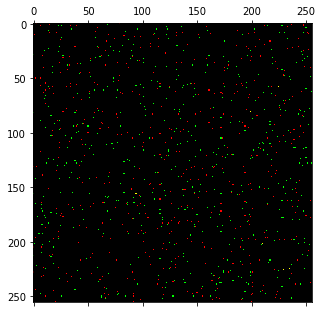

In [17]:

with File(str(Path("../../data/image_dataset/dataset_ia_2_clusters_grid_256px_tr.hdf5").resolve()),"r") as f:
    k = list(f["input"].keys())[0]
    array = np.copy(f["input"][k])
shape = (*array.shape[:2],1)
zeros = np.zeros(shape)
array = np.concatenate((array,zeros),axis=-1)
print(array.shape)
print(np.unique(array))
fig = plt.figure(figsize=(5,5))
plt.matshow(array, fignum=1)

In [26]:
df = df_src.copy().query("NUM_CLUST == 2 & IMPR_CLASS == 'BI'")
df.sort_values(by=['dataset_key'],inplace=True)
for grid in [64,128,256]:
    dico_clust_overlap = {}
    for dataset in ["tr","val"]:
        with File(str(Path(f"../../data/image_dataset/dataset_ia_2_clusters_grid_{grid}px_{dataset}.hdf5").resolve()),"r") as f:
            for k in f["input"]:
                dico_clust_overlap[k] = np.max(np.copy(f["input"][k]))
            
    elements = [dico_clust_overlap[k] for k in sorted(list(dico_clust_overlap.keys()))]
    df[f"grid_{grid}px_overlap"] = elements


In [31]:
cols = [*[f"grid_{grid}px_overlap" for grid in [64,128,256]],"INIT_CHOICE"]
print("Min")
df_aggr=df[cols].copy().groupby("INIT_CHOICE").min()
display(df_aggr)
print("Mean")
df_aggr=df[cols].copy().groupby("INIT_CHOICE").mean()
display(df_aggr)
print("Max")
df_aggr=df[cols].copy().groupby("INIT_CHOICE").max()
display(df_aggr)
print(len(df))


Min


,grid_64px_overlap,grid_128px_overlap,grid_256px_overlap
INIT_CHOICE,,,
kmeans+,2.0,2.0,1.0
random,2.0,2.0,1.0


Mean


,grid_64px_overlap,grid_128px_overlap,grid_256px_overlap
INIT_CHOICE,,,
kmeans+,3.414728,2.453727,2.037513
random,2.963928,2.140043,1.985349


Max


,grid_64px_overlap,grid_128px_overlap,grid_256px_overlap
INIT_CHOICE,,,
kmeans+,6.0,5.0,4.0
random,5.0,4.0,3.0


20000
